# One Cell

best working training model so far

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Define Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 1]
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        top = self.img_labels.iloc[idx, 3]
        left = self.img_labels.iloc[idx, 4]
        height = self.img_labels.iloc[idx, 5]
        width = self.img_labels.iloc[idx, 6]
        bbox = torch.tensor([top, left, height, width], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, bbox

# Define Custom SafeColorJitter Class without hue adjustment
class SafeColorJitter(transforms.ColorJitter):
    def __init__(self, brightness=0, contrast=0, saturation=0):
        super().__init__(brightness=brightness, contrast=contrast, saturation=saturation, hue=0)

    def get_params(self, brightness, contrast, saturation, hue=(0, 0)):
        transform_list = []
        if brightness is not None:
            brightness_factor = torch.empty(1).uniform_(brightness[0], brightness[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_brightness(img, brightness_factor))
        if contrast is not None:
            contrast_factor = torch.empty(1).uniform_(contrast[0], contrast[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_contrast(img, contrast_factor))
        if saturation is not None:
            saturation_factor = torch.empty(1).uniform_(saturation[0], saturation[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_saturation(img, saturation_factor))

        return transform_list

    def forward(self, img):
        params = self.get_params(self.brightness, self.contrast, self.saturation)
        for param in params:
            img = param(img)
        return img

# Define Transformations with SafeColorJitter without hue adjustment
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    SafeColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor()
])

# Create Dataset and DataLoader
dataset = CustomImageDataset(
    annotations_file='/Users/matt/Documents/Coding/Midjourney/MockCrop/data/training_annotations.csv',
    transform=transform
)

batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Define Improved Model with more complexity
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ImprovedCNN()

# Define Loss and Optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Move Model to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with early stopping
num_epochs = 30
best_loss = float('inf')
early_stop_patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, bboxes in train_loader:
        images, bboxes = images.to(device), bboxes.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, bboxes)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Step the scheduler
    scheduler.step()

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

print('Finished Training')

# Save the Model Checkpoint
model_save_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model3.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Load the Model Checkpoint
model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model3.pth'
model = ImprovedCNN()
model.load_state_dict(torch.load(model_load_path))
model.to(device)
model.eval()
print(f'Model loaded from {model_load_path}')

-----

improving


In [76]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Define Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 1]
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        top = self.img_labels.iloc[idx, 3]
        left = self.img_labels.iloc[idx, 4]
        height = self.img_labels.iloc[idx, 5]
        width = self.img_labels.iloc[idx, 6]
        bbox = torch.tensor([top, left, height, width], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, bbox

# Define Custom SafeColorJitter Class without hue adjustment
class SafeColorJitter(transforms.ColorJitter):
    def __init__(self, brightness=0, contrast=0, saturation=0):
        super().__init__(brightness=brightness, contrast=contrast, saturation=saturation, hue=0)

    def get_params(self, brightness, contrast, saturation, hue=(0, 0)):
        transform_list = []
        if brightness is not None:
            brightness_factor = torch.empty(1).uniform_(brightness[0], brightness[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_brightness(img, brightness_factor))
        if contrast is not None:
            contrast_factor = torch.empty(1).uniform_(contrast[0], contrast[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_contrast(img, contrast_factor))
        if saturation is not None:
            saturation_factor = torch.empty(1).uniform_(saturation[0], saturation[1]).item()
            transform_list.append(lambda img: transforms.functional.adjust_saturation(img, saturation_factor))

        return transform_list

    def forward(self, img):
        params = self.get_params(self.brightness, self.contrast, self.saturation)
        for param in params:
            img = param(img)
        return img

# Define Transformations with SafeColorJitter without hue adjustment
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    SafeColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor()
])

# Create Dataset and DataLoader
dataset = CustomImageDataset(
    annotations_file='/Users/matt/Documents/Coding/Midjourney/MockCrop/data/training_annotations.csv',
    transform=transform
)

batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Define Improved Model with more complexity
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ImprovedCNN()

# Define Loss and Optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Move Model to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with early stopping
num_epochs = 30
best_loss = float('inf')
early_stop_patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, bboxes in train_loader:
        images, bboxes = images.to(device), bboxes.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, bboxes)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Step the scheduler
    scheduler.step()

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

print('Finished Training')

# Save the Model Checkpoint
model_save_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model5.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Load the Model Checkpoint
model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model5.pth'
model = ImprovedCNN()
model.load_state_dict(torch.load(model_load_path))
model.to(device)
model.eval()
print(f'Model loaded from {model_load_path}')


Epoch [1/30], Loss: 203.2611
Epoch [2/30], Loss: 83.7341
Epoch [3/30], Loss: 74.2276
Epoch [4/30], Loss: 86.1484
Epoch [5/30], Loss: 68.6889
Epoch [6/30], Loss: 66.1423
Epoch [7/30], Loss: 75.1606
Epoch [8/30], Loss: 58.6891
Epoch [9/30], Loss: 91.5098
Epoch [10/30], Loss: 81.8314
Epoch [11/30], Loss: 90.1106
Epoch [12/30], Loss: 72.1508
Epoch [13/30], Loss: 62.6309
Epoch [14/30], Loss: 85.4216
Epoch [15/30], Loss: 54.9076
Epoch [16/30], Loss: 69.2495
Epoch [17/30], Loss: 52.6656
Epoch [18/30], Loss: 61.1820
Epoch [19/30], Loss: 70.9249
Epoch [20/30], Loss: 65.1118
Epoch [21/30], Loss: 68.1255
Epoch [22/30], Loss: 58.4021
Epoch [23/30], Loss: 76.3979
Epoch [24/30], Loss: 52.3474
Epoch [25/30], Loss: 52.3567
Epoch [26/30], Loss: 69.8716
Epoch [27/30], Loss: 66.0111
Epoch [28/30], Loss: 62.8469
Epoch [29/30], Loss: 50.6327
Epoch [30/30], Loss: 53.7915
Finished Training
Model saved to /Users/matt/Documents/Coding/Midjourney/MockCrop/models/model5.pth
Model loaded from /Users/matt/Document

model1 is the model trained with batch size = 2; learning rate = 0.0001; epochs = 10

model2 is the model trained with batch size = 2; learning rate = 0.0001; epochs = 30

model3 is the model trained with batch size = 2; lr = 0.00001; epochs = 30; did not get good results so switched lr = 0.001 and best loss results yet 

model4 was switched to batch size of 4; early stopping was triggered

model5 was switched back to batch size of 2; similar to model3 and is our best yet

-----

Validate

Model loaded from /Users/matt/Documents/Coding/Midjourney/MockCrop/models/model5.pth
Predicted Bounding Box: [225.3359, 242.1177, 318.32465, 485.84598]


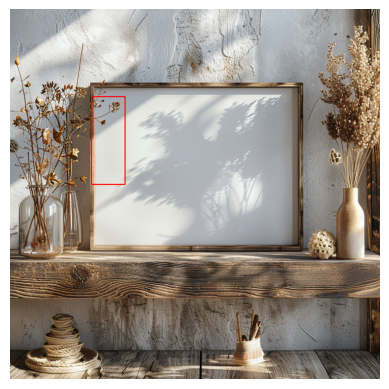

In [85]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import torch

# Load the Model Checkpoint
model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model5.pth'
model = torch.load(model_load_path)
print(f"Model loaded from {model_load_path}")

# Simulate a predicted bounding box
predicted_bbox = [225.3359, 242.1177, 318.32465, 485.84598]
print(f"Predicted Bounding Box: {predicted_bbox}")

def visualize_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    """
    Visualize bounding box on the image.
    
    Args:
    - image (np.ndarray): The input image on which to draw the bounding box.
    - bbox (list): The bounding box coordinates [x_min, y_min, x_max, y_max].
    - color (tuple): The color of the bounding box. Default is red.
    - thickness (int): The thickness of the bounding box. Default is 2.
    
    Returns:
    - image (np.ndarray): The image with the bounding box drawn.
    """
    left, top, right, bottom = bbox
    start_point = (int(left), int(top))
    end_point = (int(right), int(bottom))
    
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

def transform(image):
    """
    Transform the PIL image to a NumPy array.
    
    Args:
    - image (PIL.Image.Image): The input PIL image.
    
    Returns:
    - image (np.ndarray): The transformed NumPy array.
    """
    return np.array(image)

# Path to the new image
new_image_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/images/validate/val1.png'  # Replace with the actual path to the new image

# Visualize the bounding box on the new image
new_image = Image.open(new_image_path).convert("RGB")
new_image_np = transform(new_image)  # Transform PIL image to NumPy array
visualized_image = visualize_bbox(new_image_np, predicted_bbox)

# Display the image with bounding box
plt.imshow(visualized_image)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
new_image_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/images/validate/val1.png'  # Replace with the actual path to the new image


Model loaded from /Users/matt/Documents/Coding/Midjourney/MockCrop/models/model4.pth
Simulated Bounding Box: [225.3359, 242.1177, 318.32465, 485.84598]
Predicted Bounding Box: [np.float32(298.75607), np.float32(233.31908), np.float32(829.13293), np.float32(599.1222)]


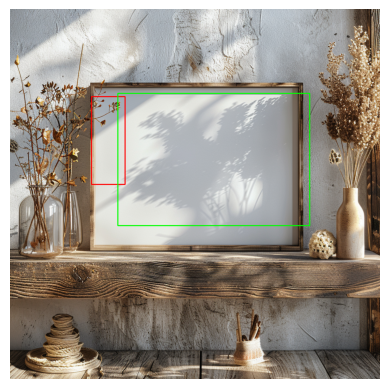

In [98]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the ImprovedCNN model architecture
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the model
model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/model4.pth'
model = ImprovedCNN()
model.load_state_dict(torch.load(model_load_path))
model.eval()
print(f"Model loaded from {model_load_path}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_predicted_bbox(model, image_path):
    """
    Get the predicted bounding box from the model.
    
    Args:
    - model (torch.nn.Module): The trained model.
    - image_path (str): The path to the input image.
    
    Returns:
    - bbox (list): The predicted bounding box coordinates [x_min, y_min, x_max, y_max].
    """
    # Load the image and preprocess as required by your model
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # Assuming output is the bounding box [top, left, height, width]
    bbox = output[0].cpu().numpy()
    top, left, height, width = bbox
    x_min, y_min, x_max, y_max = left, top, left + width, top + height
    return [x_min, y_min, x_max, y_max]

def visualize_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    """
    Visualize bounding box on the image.
    
    Args:
    - image (np.ndarray): The input image on which to draw the bounding box.
    - bbox (list): The bounding box coordinates [x_min, y_min, x_max, y_max].
    - color (tuple): The color of the bounding box. Default is red.
    - thickness (int): The thickness of the bounding box. Default is 2.
    
    Returns:
    - image (np.ndarray): The image with the bounding box drawn.
    """
    left, top, right, bottom = bbox
    start_point = (int(left), int(top))
    end_point = (int(right), int(bottom))
    
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

def transform_image(image):
    """
    Transform the PIL image to a NumPy array.
    
    Args:
    - image (PIL.Image.Image): The input PIL image.
    
    Returns:
    - image (np.ndarray): The transformed NumPy array.
    """
    return np.array(image)

# Path to the new image
new_image_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/images/validate/val1.png'  # Replace with the actual path to the new image

# Simulated bounding box (red)
simulated_bbox = [225.3359, 242.1177, 318.32465, 485.84598]
print(f"Simulated Bounding Box: {simulated_bbox}")

# Get the predicted bounding box (green)
predicted_bbox = get_predicted_bbox(model, new_image_path)
print(f"Predicted Bounding Box: {predicted_bbox}")

# Visualize both bounding boxes on the new image
new_image = Image.open(new_image_path).convert("RGB")
new_image_np = transform_image(new_image)  # Transform PIL image to NumPy array

# Draw the simulated bounding box (red)
visualized_image = visualize_bbox(new_image_np.copy(), simulated_bbox, color=(255, 0, 0), thickness=2)

# Draw the model's predicted bounding box (green)
visualized_image = visualize_bbox(visualized_image, predicted_bbox, color=(0, 255, 0), thickness=2)

# Display the image with both bounding boxes
plt.imshow(visualized_image)
plt.axis('off')  # Hide axes
plt.show()


----

# Cell by Cell

In [42]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [43]:
# Define Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 1]
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        top = self.img_labels.iloc[idx, 3]
        left = self.img_labels.iloc[idx, 4]
        height = self.img_labels.iloc[idx, 5]
        width = self.img_labels.iloc[idx, 6]
        bbox = torch.tensor([top, left, height, width], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, bbox

In [44]:
# # Define Transformations
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor()
# ])

# # Create Dataset and DataLoader
# dataset = CustomImageDataset(
#     annotations_file='/Users/matt/Documents/Coding/Midjourney/MockCrop/data/training_annotations.csv',
#     transform=transform
# )

# batch_size = 16
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [45]:
# Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor()
])

# Create Dataset and DataLoader
dataset = CustomImageDataset(
    annotations_file='/Users/matt/Documents/Coding/Midjourney/MockCrop/data/training_annotations.csv',
    transform=transform
)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [46]:
# # Define Model
# class ImprovedCNN(nn.Module):
#     def __init__(self):
#         super(ImprovedCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(64 * 64 * 64, 256)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(256, 4)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = x.view(-1, 64 * 64 * 64)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# model = ImprovedCNN()

In [47]:
# Define Improved Model with more complexity
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ImprovedCNN()


In [48]:
# # Define Loss and Optimizer
# criterion = nn.SmoothL1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# # Move Model to Device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [49]:
# Define Loss and Optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Move Model to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [50]:
# # Training Loop
# num_epochs = 25
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, bboxes in train_loader:
#         images, bboxes = images.to(device), bboxes.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(images)
        
#         # Compute loss
#         loss = criterion(outputs, bboxes)
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     epoch_loss = running_loss / len(train_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
#     # Step the scheduler
#     scheduler.step()

# print('Finished Training')

In [51]:
# Training Loop with early stopping
num_epochs = 50
best_loss = float('inf')
early_stop_patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, bboxes in train_loader:
        images, bboxes = images.to(device), bboxes.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, bboxes)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Step the scheduler
    scheduler.step()

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

print('Finished Training')


OverflowError: Python integer -3 out of bounds for uint8

In [ ]:
# # Save the Model Checkpoint
# model_save_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/improved_cnn.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f'Model saved to {model_save_path}')

In [ ]:
# # Load the Model Checkpoint
# model_load_path = '/Users/matt/Documents/Coding/Midjourney/MockCrop/models/improved_cnn.pth'
# model = ImprovedCNN()
# model.load_state_dict(torch.load(model_load_path))
# model.to(device)
# model.eval()
# print(f'Model loaded from {model_load_path}')